In [1]:
%load_ext autoreload
%autoreload 2
import glob
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

import sys
sys.path.append("..")
from dnn.ak_sample_loader import *
from dnn.torch_dataset import *
from dnn.training import *
from dnn.validation import *
from dnn.fit import fitCruijff, CruijffFitResult

In [2]:
input_files = glob.glob("/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_*.pkl")
input_samples = [AkSampleLoader.loadFromPickle(inputFile) for inputFile in input_files]
input_files

['/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_10.pkl',
 '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_200.pkl',
 '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_300.pkl',
 '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_400.pkl',
 '/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/PionSamples_v2/FixedEnergy_600.pkl']

In [3]:
from dnn.model import *
hists = [inferenceOnSavedModel("/grid_mnt/data_cms_upgrade/cuisset/ticlRegression/models/v6/largeDNN/model.pt", LargeDNN(len(features["feat-v2"])), input, feature_version="feat-v2", fixedEnergySample=True) for input in input_samples]

In [4]:
fit_results_pred = [fitCruijff(hists_en["h_pred_tot_over_cp"]) for hists_en in hists]
fit_results_reco = [fitCruijff(hists_en["h_reco_tot_over_cp"]) for hists_en in hists]

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/ticlRegression/dnn/../dnn/fit.py:45: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)


In [5]:
from typing import Literal
def plotResolution(fitRes:dict[str, dict[float, CruijffFitResult]], legendLabel:dict[str, str]=None, 
              plotMode:Literal["sigmaOverMu", "sigma", "mu"]="sigmaOverMu", ratio:bool=False,
              colors_datatype=['tab:blue', 'tab:red', 'tab:green', 'tab:purple'],
              errorbar_common_kwargs=dict(markeredgewidth=1.5, capsize=5, lw=1.5),
              errorbar_individual_kwargs=[ dict(fmt='.', markersize=10), dict(fmt='s', markersize=8, mfc='w'),]):
    """ 
    Parameters : (typeOfData is scOverCP or tsOverCP)
     - fitRes is dict : typeOfData -> pionEnergy-> CruiffFitResult
     - legendLabel : dict : typeOfData -> legend label for typeOfData
     - plotMode : plot sigma or mu
    """
    x_axis_centers = [10, 200, 300, 400, 600]

    if legendLabel is None:
        legendLabel = {typeOfData : typeOfData for typeOfData in fitRes}
    fig, main_ax = plt.subplots(figsize=(9, 8))
    main_ax.set_xlabel("Generated pion energy (GeV)")
    
    #for seedPt_bin in range(len(h.axes["seedPt"])):
    yvals_list = []
    xerr_vals = []
    for i, (typeOfData, currentFitResults) in enumerate(fitRes.items()):
        x_axis_centers = list(currentFitResults.keys())
        if plotMode == "sigmaOverMu":
            yvals = [res.params.sigmaAverage/res.params.m for res in currentFitResults.values()]
        elif plotMode == "mu":
            yvals = [res.params.m for res in currentFitResults.values()]
        
        main_ax.errorbar(x_axis_centers, yvals, xerr=None, label=legendLabel[typeOfData],
            **(dict(color=colors_datatype[i])|errorbar_common_kwargs|errorbar_individual_kwargs[i]))
        yvals_list.append(yvals)

        ## For the legend
        # main_ax.errorbar([], [], xerr = [], **(dict(color=colors_datatype[i])|errorbar_common_kwargs|errorbar_individual_kwargs[0]), label=etaBinToText(eta_bin))

    #for typeOfData, errorbar_kwargs in zip(fitRes.keys(), errorbar_individual_kwargs): # legend
    #    main_ax.errorbar([], [], xerr = [], **errorbar_kwargs, color='black', label=legendLabel[typeOfData])
    main_ax.legend()
    if plotMode == "sigma":
        main_ax.set_ylabel(r'$\sigma(E_{SC}/E_{GEN})$')
    elif plotMode == "mu":
        main_ax.set_ylabel(r'$\mu(E_{SC}/E_{GEN})$')
    hep.cms.text("Preliminary", exp="TICLv5", ax=main_ax)
    hep.cms.lumitext("PU=200", ax=main_ax)

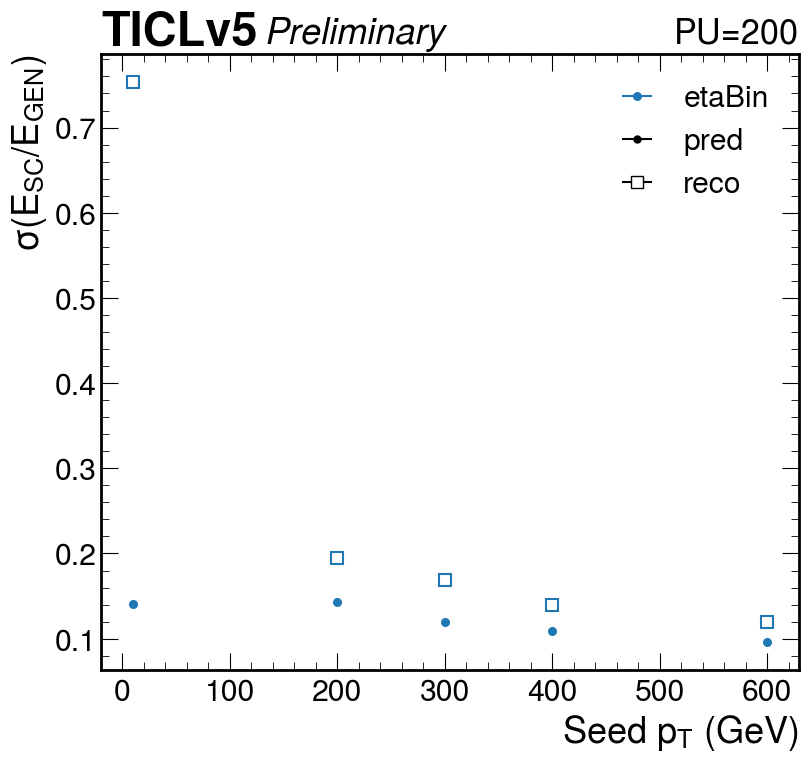

In [6]:
plotResolution({"pred" : [fit_results_pred], "reco":[fit_results_reco]})